![Colegio Bourbaki](./Images/Bourbaki.png)

### Modelo SARIMAX

**ARIMA** es un modelo de pronóstico para series temporales que combina tres componentes principales:

* **Autoregresivo (AR):** La relación entre una observación y un número de observaciones retrasadas.
* **Integrado (I):** Diferenciación de observaciones crudas para hacer la serie temporal estacionaria, es decir, para eliminar tendencia y estacionalidad.
* **Media Móvil (MA):** Dependencia entre una observación y un error residual móvil proveniente de un modelo de media móvil aplicado a observaciones retrasadas.

La notación ARIMA $(p, d, q)$ describe los componentes del modelo con:

* $p$: El número de términos autoregresivos.
* $d$: El grado de diferenciación.
* $q$: El número de términos de media móvil.

ARIMA es adecuado para series temporales que no tienen un patrón estacional claro o cuando la estacionalidad se ha eliminado previamente.

**SARIMAX** extiende el modelo ARIMA al incorporar componentes adicionales para manejar la estacionalidad y variables exógenas:

* **Componente Estacional:** Similar a la estructura ARIMA pero aplicada a la componente estacional de la serie temporal. Se describe con los parámetros estacionales (P, D, Q)m, donde P, D, y Q representan la autoregresión estacional, la diferenciación estacional, y la media móvil estacional, respectivamente, y m es el número de periodos en cada ciclo estacional.
* **Variables Exógenas (X):** Variables independientes que pueden influir en la serie temporal pero no son parte de la serie en sí. SARIMAX permite incorporar el efecto de estas variables exógenas en el modelo, mejorando la precisión del pronóstico cuando se dispone de información relevante externa.

La inclusión de componentes estacionales y variables exógenas hace que SARIMAX sea particularmente útil en situaciones donde la estacionalidad es pronunciada y/o se desea evaluar el impacto de variables externas en la serie temporal.

### Contexto

Utilizaremos la producción de Petróleo y Gas de Argentina desde 2009-01 hasta 2023-12

### Librerias

In [ ]:
# Data Analysis
import pandas as pd

# Series Temporales
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from statsmodels.tsa.arima_model import ARIMA
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

# Utils
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
from concurrent.futures import ProcessPoolExecutor
from scipy import stats
from tqdm import tqdm

In [ ]:
import warnings
warnings.filterwarnings("ignore")

### Funciones de ayuda

In [ ]:
def p_value_adfuller(data):
        fuller_test = adfuller(data)
        print('P-value: ',fuller_test[1])
        if fuller_test[1] <= 0.05:
            print('Se rechaza la hipótesis nula, los datos son estacionarios')
        else:
            print('No se rechaza la hipóteis nula, los datos no son estacionarios')

In [ ]:
def p_value_kpss(data):
        kpss_test = kpss(data)
        print('P-value: ',kpss_test[1])
        if kpss_test[1] <= 0.05:
            print('Se acepta la hipótesis nula, los datos son estacionarios')
        else:
            print('Se rechaza la hipóteis nula, los datos no son estacionarios')

In [ ]:
# Function to train SARIMAX model and calculate AIC
def train_sarimax_model(params):
    parametros, parametros_s, data, column_name = params
    try:
        modelo = SARIMAX(data,
                         order=parametros,
                         seasonal_order=parametros_s,
                         enforce_stationarity=False,
                         enforce_invertibility=False)
        results = modelo.fit(disp=False)
        return (parametros, parametros_s, results.aic, column_name)  # Include column_name in the result
    except Exception as e:
        return (parametros, parametros_s, float('inf'), column_name)  # Include column_name in case of error

### Producción de Petróleo y Gas

In [ ]:
df_oil = pd.read_csv('./Data/petroleo_diaria_pais.csv')
df_gas = pd.read_csv('./Data/gas_diaria_pais.csv')

In [ ]:
df_oil.head()

In [ ]:
df_gas.head()

In [ ]:
df = pd.merge(df_oil, df_gas)  

In [ ]:
df

In [ ]:
df["Date"] = pd.to_datetime(df["indice_tiempo"])
df = df.set_index('Date')

In [ ]:
df['produccion_petroleo_promedio_dia_km3'] = df['produccion_petroleo_promedio_dia_m3']/1000
df['produccion_gas_promedio_dia_Mm3'] = df['produccion_gas_promedio_dia_mm3']/1000

Revisamos si las fechas están ordenadas:

In [ ]:
df.index.is_monotonic_increasing

Para algunas funciones de ST es importante indicar la frecuencia de nuestros datos:

In [ ]:
df.index.freq = df.index.inferred_freq
df.index

Para más información de las frecuencias en pandas consultar el apartado DateOffset objects en [este enlace](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)

### Exploración y Visualización de la Serie Temporal

In [ ]:
df['produccion_petroleo_promedio_dia_km3'].plot(figsize=(10,5), title='Producción Hidrocarburos Diaria Promedio Argentina', color='green', label='Producción Petroleo Diaria Promedio Argentina (km3)')
df['produccion_gas_promedio_dia_Mm3'].plot(figsize=(10,5), color='red', label='Producción Gas Diaria Promedio Argentina (Mm3)')
plt.legend()
plt.show()

In [ ]:
df['produccion_petroleo_promedio_dia_km3'].rolling(12).mean().plot(figsize=(10,5),label='Media Móvil Petróleo c/12 meses')
df['produccion_petroleo_promedio_dia_km3'].plot(color='green')
df['produccion_gas_promedio_dia_Mm3'].rolling(12).mean().plot(figsize=(10,5),label='Media Móvil Gas c/12 meses')
df['produccion_gas_promedio_dia_Mm3'].plot(color='red')
plt.legend()
plt.show()

La funcion seasonal_decompose() de statsmodels, descompone la serie en tres partes: tendencia, estacionalidad y residuos.

**Tendencia:**

La tendencia es un componente de la serie temporal que muestra un patrón persistente y de largo plazo, generalmente hacia arriba o hacia abajo, indicando un aumento o disminución en los datos a lo largo del tiempo. No tiene que ser lineal necesariamente; también puede ser exponencial o de cualquier otra forma que muestre una dirección consistente a lo largo de un período extenso. En SARIMAX, la parte "Integrada" (I) ayuda a manejar y estabilizar la tendencia en los datos, haciendo la serie estacionaria mediante diferenciación, lo cual es esencial para aplicar los componentes AR y MA.

**Estacionaridad:**

La estacionaridad se refiere a patrones o ciclos que se repiten a intervalos regulares dentro de la serie temporal, como diariamente, mensualmente, anualmente, etc. Estos patrones son predecibles y se atribuyen a factores estacionales, como el clima, los hábitos de compra, las festividades, entre otros. La componente "Seasonal" en SARIMAX modela explícitamente esta estacionalidad utilizando términos autoregresivos y de media móvil que se aplican a los ciclos estacionales de los datos, permitiendo que el modelo ajuste y prediga efectivamente estas variaciones periódicas.

**Residuos:**

Los residuos, en el contexto de modelado de series temporales, son la diferencia entre los valores observados y los valores ajustados (o predichos) por el modelo. En un modelo bien ajustado, los residuos deberían ser aleatorios y exhibir propiedades de ruido blanco, lo que significa que no tienen patrones predecibles, no están correlacionados y tienen una media constante cercana a cero. Los residuos representan la parte de la serie temporal que el modelo no puede explicar, y su análisis es crucial para evaluar la adecuación del modelo. Si los residuos muestran patrones no aleatorios o estacionalidad, esto sugiere que el modelo no ha capturado completamente toda la estructura de los datos, indicando la necesidad de revisar y posiblemente mejorar el modelo.


In [ ]:
decomp_oil = seasonal_decompose(df['produccion_petroleo_promedio_dia_km3'], period=12, extrapolate_trend='freq')
fig = decomp_oil.plot()
fig.set_size_inches(10,7)

In [ ]:
decomp_gas = seasonal_decompose(df['produccion_gas_promedio_dia_Mm3'], period=12, extrapolate_trend='freq')
fig = decomp_gas.plot()
fig.set_size_inches(10,7)

### Datos Estacionarios

Test de DF:

El test de Dickey-Fuller, específicamente el test de Dickey-Fuller Aumentado (ADF, por sus siglas en inglés Augmented Dickey-Fuller), es una prueba estadística utilizada para determinar si una serie temporal es estacionaria o no, enfocándose en la presencia de una raíz unitaria. Una serie temporal es estacionaria si sus propiedades estadísticas, como la media y la varianza, son constantes a lo largo del tiempo. La estacionalidad es una propiedad deseada en muchos modelos de series temporales porque facilita la predicción de futuros valores.

El test de Dickey-Fuller Aumentado verifica la hipótesis nula $(H_0​)$ de que una serie temporal tiene una raíz unitaria, lo que indica que no es estacionaria. Una raíz unitaria significa que la serie temporal puede ser representada por un proceso autorregresivo que tiene uno o más coeficientes igual a uno, lo cual es indicativo de un patrón persistente que no retorna a una media a largo plazo.

**Hipótesis del Test:**

* Hipótesis Nula $(H_0​)$: La serie temporal tiene una raíz unitaria (no es estacionaria).
* Hipótesis Alternativa $(H_1​)$: La serie temporal no tiene una raíz unitaria (es estacionaria).

**Interpretación del Test:**

La decisión de rechazar o no la hipótesis nula se basa en el valor p del test. Si el valor p es menor que un nivel de significancia predefinido (por ejemplo, 0.05), entonces se rechaza la hipótesis nula en favor de la hipótesis alternativa, sugiriendo que la serie temporal es estacionaria.

El test de Dickey-Fuller Aumentado es una herramienta esencial en el análisis de series temporales, especialmente antes de ajustar modelos como ARIMA, donde la estacionariedad de la serie es un requisito. Identificar y corregir la no estacionariedad (por ejemplo, mediante diferenciación) es un paso crítico en el proceso de modelado de series temporales.

**Limitaciones:**

Aunque el test ADF es ampliamente utilizado, tiene algunas limitaciones, como su sensibilidad al número de retrasos incluidos en el modelo y su tendencia a no detectar estacionariedad en presencia de cambios estructurales en la serie temporal. Por estas razones, a menudo se utiliza en conjunto con otras pruebas y análisis gráficos para una evaluación más completa de la estacionariedad.

Test de KPSS:

El KPSS es otra prueba para comprobar la estacionariedad de una serie temporal. Las hipótesis nula y alternativa de la prueba KPSS son opuestas a las de la prueba ADF.

* Hipótesis nula: El proceso es estacionario en cuanto a la tendencia.

* Hipótesis alternativa: La serie tiene una raíz unitaria (la serie no es estacionaria).

Primero, veamos el clase de la serie temporal del petróleo:

In [ ]:
p_value_adfuller(df['produccion_petroleo_promedio_dia_km3'])

In [ ]:
p_value_kpss(df['produccion_petroleo_promedio_dia_km3'])

Como los datos no son estacionarios, no se rechazan la hipótesis nula. Vamos a hacer un shift de una unidad:

In [ ]:
df['1a_diffoil']= df['produccion_petroleo_promedio_dia_km3'] - df['produccion_petroleo_promedio_dia_km3'].shift(1) 
df['1a_diffoil'].plot(figsize=(10,4))
plt.show()

In [ ]:
p_value_adfuller(df['1a_diffoil'].dropna())

In [ ]:
p_value_kpss(df['1a_diffoil'].dropna())

Veamos el caso de la serie del Gas:

In [ ]:
p_value_adfuller(df['produccion_gas_promedio_dia_Mm3'])

In [ ]:
p_value_kpss(df['produccion_gas_promedio_dia_Mm3'])

Los datos son estacionarios.

### Visualización de la ACF y PACF

Para el petróleo:

In [ ]:
plot_acf(df['produccion_petroleo_promedio_dia_km3'].dropna())
plot_pacf(df['produccion_petroleo_promedio_dia_km3'].dropna())
plt.show()

In [ ]:
plot_acf(df['1a_diffoil'].dropna())
plot_pacf(df['1a_diffoil'].dropna())
plt.show()

Para el gas:

In [106]:
test_oil

Date
2023-01-01     97.932719
2023-02-01     99.723437
2023-03-01    100.341004
2023-04-01     99.818531
2023-05-01     99.842331
2023-06-01     98.615545
2023-07-01     98.073740
2023-08-01     98.899721
2023-09-01    101.249593
2023-10-01    103.903309
2023-11-01    105.964143
2023-12-01    107.396217
Freq: MS, Name: produccion_petroleo_promedio_dia_km3, dtype: float64

In [ ]:
plot_acf(df['produccion_gas_promedio_dia_Mm3'])
plot_pacf(df['produccion_gas_promedio_dia_Mm3'])
plt.show()

### Construcción del modelo SARIMAx

Pueden revisar la documentación de statsmodels sobre Time Series Analysis, es muy interesante: https://www.statsmodels.org/stable/examples/index.html#time-series-analysis

In [103]:
train_oil = df.loc[:'2022-12-1','produccion_petroleo_promedio_dia_km3']
test_oil = df.loc['2023-1-1':,'produccion_petroleo_promedio_dia_km3']
train_gas = df.loc[:'2022-12-1','produccion_gas_promedio_dia_Mm3']
test_gas = df.loc['2023-1-1':,'produccion_gas_promedio_dia_Mm3']

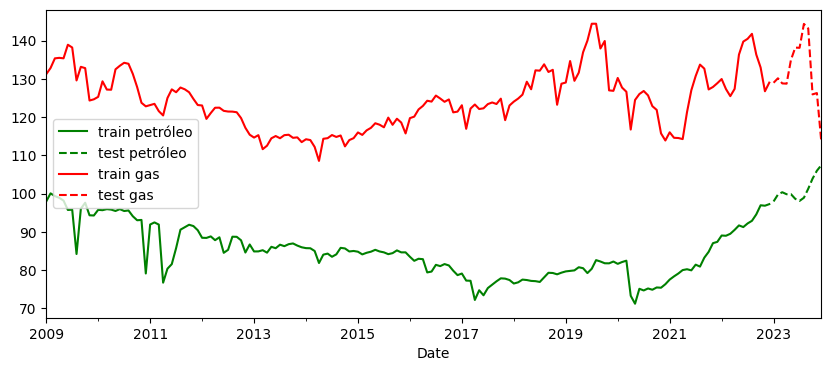

In [104]:
train_oil.plot(label = 'train petróleo', figsize =(10,4), color='green')
test_oil.plot(label = 'test petróleo', figsize =(10,4), color='green', linestyle='--')
train_gas.plot(label = 'train gas', figsize =(10,4), color='red')
test_gas.plot(label = 'test gas', figsize =(10,4), color='red', linestyle='--')
plt.legend()
plt.show()

In [ ]:
len(train_oil), len(test_oil)

In [ ]:
print(f'Porcentaje de datos de prueba para el petróleo: {100*len(test_oil)/(len(train_oil)+len(test_oil)):.2f}')
print(f'Porcentaje de datos de prueba para el gas: {100*len(test_gas)/(len(train_gas)+len(test_gas)):.2f}')

Vamos a generar una combinación de los parámetros de los modelos SARIMAX:

In [ ]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
pdq

In [ ]:
p = d = q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq

El criterio de información de Akaike (AIC, por sus siglas en inglés, Akaike Information Criterion) es una medida utilizada en estadística para la selección de modelos. En el contexto del código que proporcionaste, donde se ajustan modelos SARIMAX a series temporales, el AIC se utiliza para comparar diferentes modelos entre sí y seleccionar el mejor.

El AIC es un criterio basado en la teoría de la información que busca encontrar el modelo que mejor explica los datos con la menor cantidad de parámetros. Proporciona un balance entre la complejidad del modelo (número de parámetros) y su ajuste a los datos. Un modelo que se ajusta perfectamente pero que usa demasiados parámetros puede capturar el ruido en lugar de la señal (overfitting), mientras que un modelo con pocos parámetros puede no capturar toda la estructura de los datos (underfitting).

Interpretación del AIC

* Valor Absoluto del AIC: Por sí solo, el valor absoluto del AIC no tiene un significado inherente. Lo importante es la diferencia relativa en los valores de AIC entre diferentes modelos.
* Comparación de Modelos: Entre dos o más modelos, el que tiene el menor AIC se considera el "mejor", en el sentido de que tiene un equilibrio óptimo entre ajuste y complejidad.
* Diferencia de AIC: Una diferencia de AIC de 2 o más se considera sustancial. Sin embargo, cuando las diferencias son pequeñas (por ejemplo, menos de 2), puede no haber una preferencia clara entre los modelos comparados.

Aplicación en SARIMAX

En el ajuste de modelos SARIMAX a datos de series temporales, el AIC se utiliza para elegir entre diferentes combinaciones de órdenes autoregresivas (AR), integradas (I), medias móviles (MA), y componentes estacionales. Seleccionar el modelo con el AIC más bajo ayuda a prevenir tanto la sobreadaptación como la subadaptación, facilitando la elección de un modelo que generalice bien a nuevos datos.

In [ ]:
# UTILIZAR ESTE CODIGO EN CASO DE TENER PROBLEMAS CON LA CLASE POOLPROCESSING, TARDA EL DOBLE.

# %%time

# aic_modelos_oil = {}
# aic_modelos_gas = {}

# # Loop para iterar a través de combinaciones de parámetros.
# for parametros in pdq:
#     for parametros_s in seasonal_pdq:
#         try:
#             modelo_oil = SARIMAX(df.loc[:'2023-1-1', 'produccion_petroleo_promedio_dia_km3'],
#                              order=parametros,
#                              seasonal_order=parametros_s,
#                              enforce_stationarity=False,
#                              enforce_invertibility=False)
#             results_oil = modelo_oil.fit(disp=False)  # Añadido disp=False para minimizar la salida durante el ajuste
#             aic_modelos_oil[(parametros, parametros_s)] = results_oil.aic
#             print(f'Petróleo: ARIMA{parametros}x{parametros_s} - AIC:{results_oil.aic}')
#         except Exception as e:
#             print(f'Error con ARIMA{parametros}x{parametros_s}: {e}')
#             continue
#         try:
#             modelo_gas = SARIMAX(df.loc[:'2023-1-1', 'produccion_gas_promedio_dia_Mm3'],
#                              order=parametros,
#                              seasonal_order=parametros_s,
#                              enforce_stationarity=False,
#                              enforce_invertibility=False)
#             results_gas = modelo_gas.fit(disp=False)
#             aic_modelos_gas[(parametros, parametros_s)] = results_gas.aic
#             print(f'Gas: ARIMA{parametros}x{parametros_s} - AIC:{results_gas.aic}')
#         except Exception as e:
#             print(f'Error con ARIMA{parametros}x{parametros_s}: {e}')
#             continue

In [34]:
# Data and column names
column_names = ['Oil', 'Gas']

# Combine parameters and data for both oil and gas
params_and_data = [(param, param_s, data, column_names[i]) for param in pdq for param_s in seasonal_pdq for i, data in enumerate([train_oil, train_gas])]

# Use parallel processing to train models concurrently with tqdm progress bar
with ProcessPoolExecutor(max_workers=int(os.cpu_count())) as executor, tqdm(total=len(params_and_data)) as pbar:
    results = list(executor.map(train_sarimax_model, params_and_data))
    pbar.update()

  0%|          | 1/8192 [9:21:12<76613:18:34, 33672.07s/it]


In [80]:
aic_modelos_oil = {}
aic_modelos_gas = {}

# Organize results
for result in results:
    parametros, parametros_s, aic, column_name = result
    if column_name == 'Oil':
        aic_modelos_oil[(parametros, parametros_s)] = aic
        print(f'Petróleo: SARIMAx{parametros}x{parametros_s} - AIC:{aic:.3f}')
    elif column_name == 'Gas':
        aic_modelos_gas[(parametros, parametros_s)] = aic
        print(f'Gas: SARIMAx{parametros}x{parametros_s} - AIC:{aic:.3f}\n')

Petróleo: SARIMAx(0, 0, 0)x(0, 0, 0, 12) - AIC:1971.677
Gas: SARIMAx(0, 0, 0)x(0, 0, 0, 12) - AIC:2100.070

Petróleo: SARIMAx(0, 0, 0)x(0, 0, 1, 12) - AIC:1660.803
Gas: SARIMAx(0, 0, 0)x(0, 0, 1, 12) - AIC:1779.341

Petróleo: SARIMAx(0, 0, 0)x(0, 0, 2, 12) - AIC:1399.783
Gas: SARIMAx(0, 0, 0)x(0, 0, 2, 12) - AIC:1508.757

Petróleo: SARIMAx(0, 0, 0)x(0, 0, 3, 12) - AIC:1193.771
Gas: SARIMAx(0, 0, 0)x(0, 0, 3, 12) - AIC:1303.904

Petróleo: SARIMAx(0, 0, 0)x(0, 1, 0, 12) - AIC:996.302
Gas: SARIMAx(0, 0, 0)x(0, 1, 0, 12) - AIC:1056.629

Petróleo: SARIMAx(0, 0, 0)x(0, 1, 1, 12) - AIC:920.074
Gas: SARIMAx(0, 0, 0)x(0, 1, 1, 12) - AIC:981.292

Petróleo: SARIMAx(0, 0, 0)x(0, 1, 2, 12) - AIC:817.905
Gas: SARIMAx(0, 0, 0)x(0, 1, 2, 12) - AIC:889.480

Petróleo: SARIMAx(0, 0, 0)x(0, 1, 3, 12) - AIC:721.974
Gas: SARIMAx(0, 0, 0)x(0, 1, 3, 12) - AIC:806.757

Petróleo: SARIMAx(0, 0, 0)x(0, 2, 0, 12) - AIC:1011.577
Gas: SARIMAx(0, 0, 0)x(0, 2, 0, 12) - AIC:1088.726

Petróleo: SARIMAx(0, 0, 0)x(0, 2, 1

In [36]:
print('Modelo Petróleo: ', min(aic_modelos_oil, key = aic_modelos_oil.get))
print('AIC Petróleo: ',min(aic_modelos_oil.values()))
print('Modelo Gas: ', min(aic_modelos_gas, key = aic_modelos_gas.get))
print('AIC Gas: ',min(aic_modelos_gas.values()))

Modelo Petróleo:  ((0, 2, 1), (0, 2, 3, 12))
AIC Petróleo:  10.0
Modelo Gas:  ((0, 3, 1), (1, 2, 3, 12))
AIC Gas:  12.0


Para el petróleo:

In [87]:
sarimax_oil = SARIMAX(train_oil,
                       order = min(aic_modelos_oil, key = aic_modelos_oil.get)[0],
                       seasonal_order = min(aic_modelos_oil, key = aic_modelos_oil.get)[1],
                       enforce_stationarity = False,
                       enforce_invertibility = False)
resultados_oil = sarimax_oil.fit()
print(resultados_oil.summary().tables[1])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.00904D+01    |proj g|=  9.29238D-02
  ys=-4.308E+06  -gs= 5.485E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      4     69      2     1     0   1.885D+06  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.7035   2.36e-08   7.22e+07      0.000       1.703       1.703
ma.S.L12    6.509e+12         -0       -inf      0.000    6.51e+12    6.51e+12
ma.S.L24   -1.426e+13         -0        inf      0.000   -1.43e+13   -1.43e+13
ma.S.L36    3.147e+13       

In [38]:
resultados_oil.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:       produccion_petroleo_promedio_dia_km3   No. Observations:                  180
Model:             SARIMAX(0, 2, 1)x(0, 2, [1, 2, 3], 12)   Log Likelihood                -259.403
Date:                                    Sat, 10 Feb 2024   AIC                            528.806
Time:                                            08:06:28   BIC                            542.574
Sample:                                        01-01-2009   HQIC                           534.395
                                             - 12-01-2023                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000     82.888     -0.012      0.990    -163.457     161.457
ma.S.L12      -7.9745     22.834     -0.349      0.727     -52.728      36.779
ma.S.L24      13.0249     63.146      0.206      0.837    -110.739     136.789
ma.S.L36      -4.2716     31.928     -0.134      0.894     -66.850      58.307
sigma2         0.0511      4.268      0.012      0.990      -8.313       8.415
===================================================================================
Ljung-Box (L1) (Q):                   4.83   Jarque-Bera (JB):               105.28
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -0.54
Prob(H) (two-sided):                  0.03   Kurtosis:                         7.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Gráficos diagnóstico:

**Gráfico de Residuos Estandarizados:** Muestra los residuos del modelo a lo largo del tiempo. Los residuos son las diferencias entre los valores observados y los valores predichos por el modelo. Este gráfico ayuda a evaluar si los residuos parecen ser aleatorios (sin patrones) y si tienen varianza constante a lo largo del tiempo, dos propiedades importantes para un buen modelo de series temporales.

**Histograma con Densidad Estimada:**
        
* Histograma (Hist): Representa la distribución de frecuencias de los residuos. En un buen modelo, esperaríamos que los residuos sigan aproximadamente una distribución normal centrada en cero.
* Estimación de Densidad Núcleo (KDE): Es una curva suave que estima la densidad de probabilidad de los residuos. Si se asemeja a la curva de la distribución normal (N(0,1)), sugiere que los residuos podrían ser normalmente distribuidos.
* N(0,1): Es la curva de la distribución normal estándar para comparación. Idealmente, el histograma y la KDE deben seguir de cerca esta línea si los residuos están normalmente distribuidos.

**Gráfico Q-Q Normal (Quantile-Quantile):** Compara los cuantiles de los residuos con los cuantiles de una distribución normal estándar. Si los puntos caen aproximadamente a lo largo de la línea roja (que representa la igualdad de cuantiles), sugiere que los residuos tienen una distribución normal. Las desviaciones de esta línea indican desviaciones de la normalidad.

**Correlograma:** Muestra la autocorrelación de los residuos en diferentes lags. En un modelo bien ajustado, esperaríamos que todas las autocorrelaciones estén cerca de cero y dentro de la banda de confianza azul (que representa el rango en el que se considerarían estadísticamente insignificantes). Esto indicaría que no hay autocorrelación significativa en los residuos y que el modelo ha capturado adecuadamente la dependencia temporal en los datos.

En resumen, estos gráficos se utilizan para diagnosticar la calidad de un modelo estadístico, con un enfoque en la aleatoriedad, la distribución y la independencia de los residuos. Si los residuos no cumplen con estas condiciones, el modelo puede no ser apropiado o requerir modificaciones.

LinAlgError: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

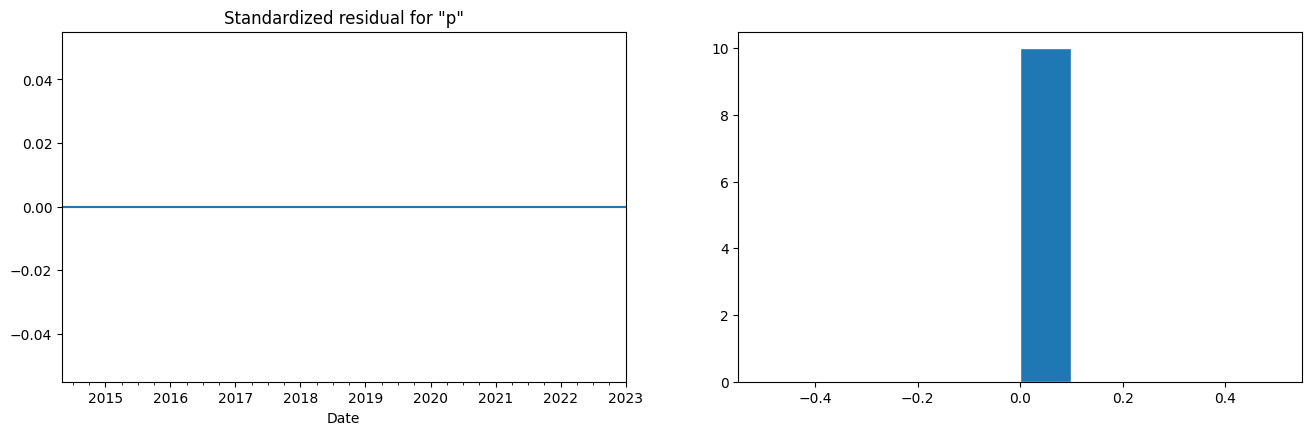

In [88]:
resultados_oil.plot_diagnostics(figsize = (16,10))
plt.show()

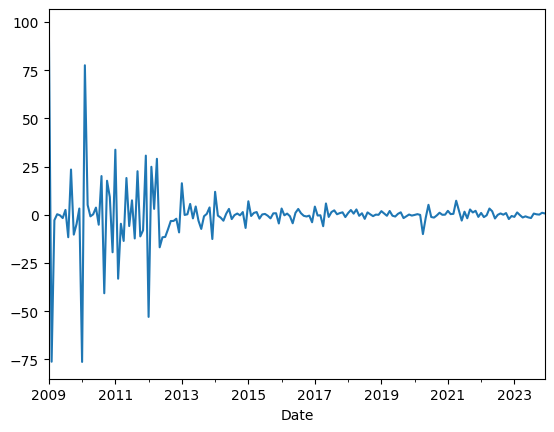

In [40]:
resultados_oil.resid.plot()
plt.show()

In [43]:
stats.normaltest(resultados_oil.resid)

NormaltestResult(statistic=70.77724528759629, pvalue=4.274806525222072e-16)

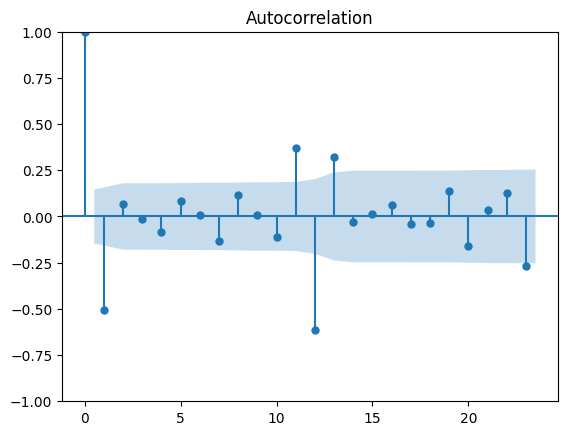

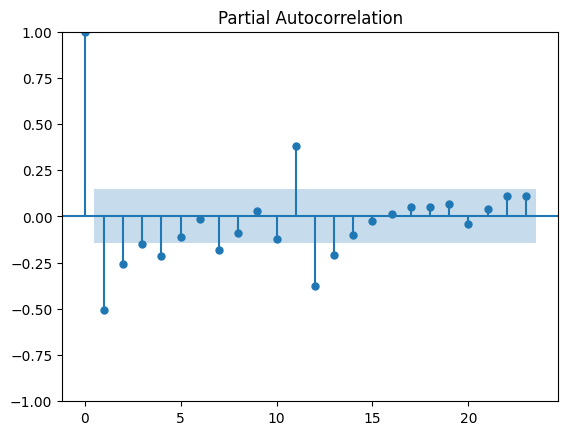

In [44]:
plot_acf(resultados_oil.resid)
plot_pacf(resultados_oil.resid)
plt.show()

Para el gas:

In [45]:
sarimax_gas = SARIMAX(train_gas,
                       order = min(aic_modelos_gas, key = aic_modelos_gas.get)[0],
                       seasonal_order = min(aic_modelos_gas, key = aic_modelos_gas.get)[1],
                       enforce_stationarity = False,
                       enforce_invertibility = False)
resultados_gas = sarimax_gas.fit()
print(resultados_gas.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23081D+00    |proj g|=  4.24336D-01


 This problem is unconstrained.



At iterate    5    f=  2.47915D+00    |proj g|=  2.18701D-01

At iterate   10    f=  2.32741D+00    |proj g|=  2.50007D-01

At iterate   15    f=  2.19694D+00    |proj g|=  1.75786D-01

At iterate   20    f=  2.10546D+00    |proj g|=  2.00584D-01

At iterate   25    f=  2.09633D+00    |proj g|=  6.98758D-02

At iterate   30    f=  2.08797D+00    |proj g|=  6.45434D-03

At iterate   35    f=  2.08791D+00    |proj g|=  2.39392D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     47      1     0     0   7.366D-06   2.088D+00
  F =   2.0879115297375836     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

In [46]:
resultados_gas.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:            produccion_gas_promedio_dia_Mm3   No. Observations:                  180
Model:             SARIMAX(0, 3, 1)x(1, 2, [1, 2, 3], 12)   Log Likelihood                -375.824
Date:                                    Sat, 10 Feb 2024   AIC                            763.648
Time:                                            10:16:04   BIC                            780.118
Sample:                                        01-01-2009   HQIC                           770.333
                                             - 12-01-2023                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000    910.714     -0.001      0.999   -1785.966    1783.966
ar.S.L12      -0.5286      0.444     -1.192      0.233      -1.398       0.341
ma.S.L12      -0.7826      0.558     -1.402      0.161      -1.877       0.311
ma.S.L24      -0.4646      0.621     -0.748      0.455      -1.682       0.753
ma.S.L36       0.3124      0.198      1.575      0.115      -0.076       0.701
sigma2        34.7940   3.17e+04      0.001      0.999   -6.21e+04    6.21e+04
===================================================================================
Ljung-Box (L1) (Q):                  53.55   Jarque-Bera (JB):                17.41
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.42   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

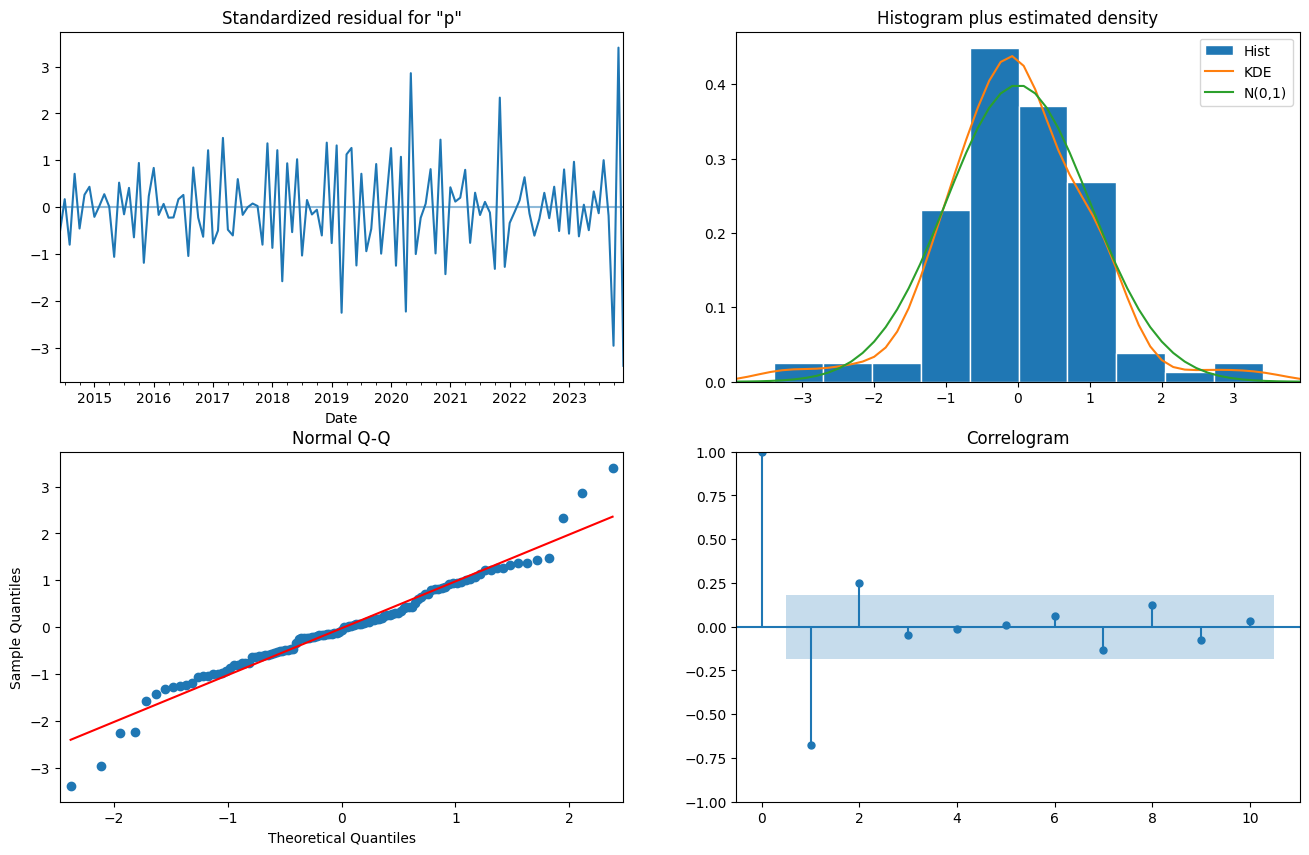

In [47]:
resultados_gas.plot_diagnostics(figsize = (16,10))
plt.show()

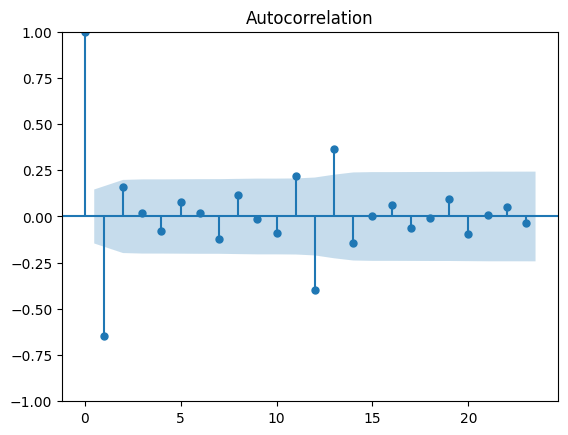

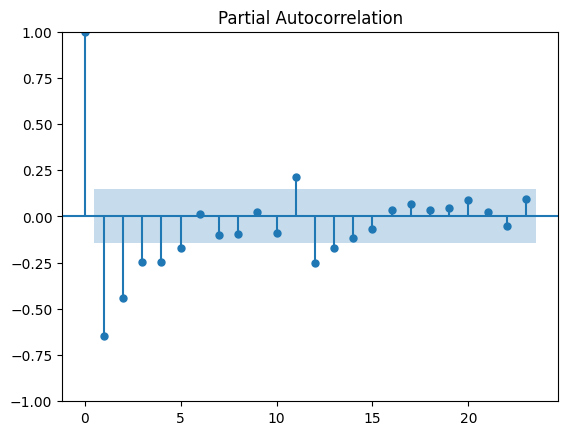

In [48]:
plot_acf(resultados_gas.resid)
plot_pacf(resultados_gas.resid)
plt.show()

In [49]:
stats.normaltest(resultados_gas.resid)

NormaltestResult(statistic=145.20004302121882, pvalue=2.952645255089725e-32)

### Testing

In [50]:
pred_oil = resultados_oil.get_prediction(start=pd.to_datetime('2023-01-01'),
                                 end=pd.to_datetime('2026-01-01'))
pred_IC_oil = pred_oil.conf_int()
pred_gas = resultados_gas.get_prediction(start=pd.to_datetime('2023-01-01'),
                                 end=pd.to_datetime('2026-01-01'))
pred_IC_gas = pred_gas.conf_int()

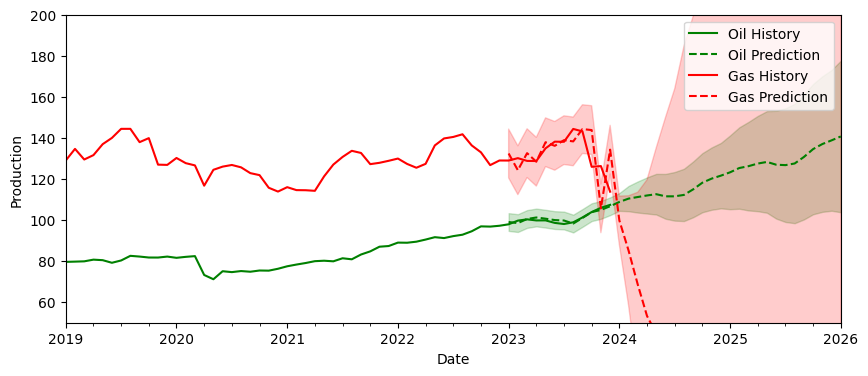

In [83]:
fig = df.loc['2019-01-01':,'produccion_petroleo_promedio_dia_km3'].plot(label = 'Oil History', 
                                           figsize =(10,4), color='green')
pred_oil.predicted_mean.plot(ax = fig, label = 'Oil Prediction', color='green', linestyle='--')
fig.fill_between(pred_IC_oil.index, 
                 pred_IC_oil.iloc[:,0], pred_IC_oil.iloc[:,1], 
                 color='green', alpha=.2)
fig = df.loc['2019-01-01':,'produccion_gas_promedio_dia_Mm3'].plot(label = 'Gas History', 
                                           figsize =(10,4), color='red')
pred_gas.predicted_mean.plot(ax = fig, label = 'Gas Prediction', color='red', linestyle='--')
fig.fill_between(pred_IC_gas.index, 
                 pred_IC_gas.iloc[:,0], pred_IC_gas.iloc[:,1], 
                 color='red', alpha=.2)
plt.ylabel('Production')
plt.ylim(50,200)
plt.legend()
plt.show()

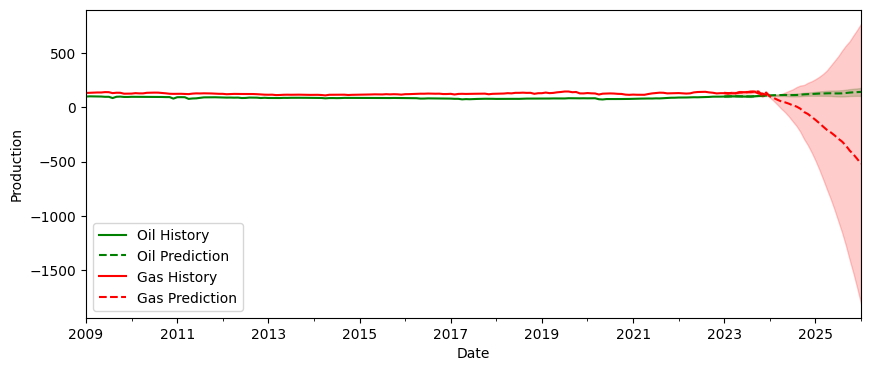

In [52]:
fig = df.loc['2009-01-01':,'produccion_petroleo_promedio_dia_km3'].plot(label = 'Oil History', 
                                           figsize =(10,4), color='green')
pred_oil.predicted_mean.plot(ax = fig, label = 'Oil Prediction', color='green', linestyle='--')
fig.fill_between(pred_IC_oil.index, 
                 pred_IC_oil.iloc[:,0], pred_IC_oil.iloc[:,1], 
                 color='green', alpha=.2)

fig = df.loc['2009-01-01':,'produccion_gas_promedio_dia_Mm3'].plot(label = 'Gas History', 
                                           figsize =(10,4), color='red')
pred_gas.predicted_mean.plot(ax = fig, label = 'Gas Prediction', color='red', linestyle='--')
fig.fill_between(pred_IC_gas.index, 
                 pred_IC_gas.iloc[:,0], pred_IC_gas.iloc[:,1], 
                 color='red', alpha=.2)

plt.ylabel('Production')
plt.legend()
plt.show()

In [53]:
y_pred_oil  = pred_oil.predicted_mean[:12]
y_real_oil = df.loc['2023-01-01':'2026-01-01','produccion_petroleo_promedio_dia_km3']
mse = ((y_pred_oil - y_real_oil) ** 2).mean()
print(f'El error cuadrático medio es {round(mse, 2)}')
print(f'La raiz del error cuadrático medio es {round(np.sqrt(mse), 2)}')
print(f"Porcentaje de error con respecto al promedio: {round(100*np.sqrt(mse)/(df['produccion_petroleo_promedio_dia_km3'].mean()), 3)} %")

El error cuadrático medio es 1.01
La raiz del error cuadrático medio es 1.01
Porcentaje de error con respecto al promedio: 1.171 %


In [54]:
y_pred_gas  = pred_gas.predicted_mean[:12]
y_real_gas = df.loc['2023-01-01':'2026-01-01','produccion_gas_promedio_dia_Mm3']
mse = ((y_pred_gas - y_real_gas) ** 2).mean()
print(f'El error cuadrático medio es {round(mse, 2)}')
print(f'La raiz del error cuadrático medio es {round(np.sqrt(mse), 2)}')
print(f"Porcentaje de error con respecto al promedio: {round(100*np.sqrt(mse)/(df['produccion_gas_promedio_dia_Mm3'].mean()), 3)} %")

El error cuadrático medio es 106.32
La raiz del error cuadrático medio es 10.31
Porcentaje de error con respecto al promedio: 8.255 %


### Prophet

Prophet es un procedimiento de previsión de datos de series temporales basado en un modelo aditivo en el que las tendencias no lineales se ajustan con estacionalidad anual, semanal y diaria, además de efectos de vacaciones. Funciona mejor con series temporales que tienen fuertes efectos estacionales y varias temporadas de datos históricos. Prophet es resistente a los datos que faltan y a los cambios en la tendencia, y suele manejar bien los valores atípicos.

Prophet es un software de código abierto publicado por el equipo de ciencia de datos básicos de Facebook. Se puede descargar en CRAN y PyPI.

**Preciso y rápido:**

Prophet se utiliza en muchas aplicaciones de Facebook para elaborar previsiones fiables para la planificación y el establecimiento de objetivos. Hemos comprobado que, en la mayoría de los casos, ofrece mejores resultados que cualquier otro método. Ajustamos modelos en Stan para que obtengas previsiones en tan solo unos segundos.

**Totalmente automático:**

Obtenga una previsión razonable con datos desordenados sin esfuerzo manual. Prophet es robusto frente a valores atípicos, datos perdidos y cambios drásticos en las series temporales.

**Previsiones ajustables:**

El procedimiento Prophet incluye muchas posibilidades para que los usuarios ajusten las previsiones. Puede utilizar parámetros interpretables por el ser humano para mejorar su previsión añadiendo su conocimiento del dominio.

**Disponible en R o Python:**

Hemos implementado el procedimiento Prophet en R y Python, pero comparten el mismo código Stan subyacente para el ajuste. Utilice cualquier lenguaje con el que se sienta cómodo para obtener previsiones.

Pueden decodificar Prophet aquí: https://medium.com/@jain.sm/facebook-prophet-decoded-e7af322f56c2

In [55]:
#Convert 'date' to datetime and rename columns for Prophet
df_oil['ds'] = pd.to_datetime(df_oil['indice_tiempo'])
df_oil.rename(columns={'produccion_petroleo_promedio_dia_m3': 'y'}, inplace=True)
df_gas['ds'] = pd.to_datetime(df_oil['indice_tiempo'])
df_gas.rename(columns={'produccion_gas_promedio_dia_mm3': 'y'}, inplace=True)

In [56]:
df_oil

,anio,mes,indice_tiempo,y,ds
0,2009,1,2009-01,97924.5991,2009-01-01
1,2009,2,2009-02,100044.0659,2009-02-01
2,2009,3,2009-03,99329.5204,2009-03-01
3,2009,4,2009-04,98880.3859,2009-04-01
4,2009,5,2009-05,98151.9991,2009-05-01
...,...,...,...,...,...
175,2023,8,2023-08,98899.7214,2023-08-01
176,2023,9,2023-09,101249.5925,2023-09-01
177,2023,10,2023-10,103903.3087,2023-10-01
178,2023,11,2023-11,105964.1426,2023-11-01


In [57]:
df_gas

,anio,mes,indice_tiempo,y,ds
0,2009,1,2009-01,131223.0108,2009-01-01
1,2009,2,2009-02,132833.2683,2009-02-01
2,2009,3,2009-03,135361.2048,2009-03-01
3,2009,4,2009-04,135493.2462,2009-04-01
4,2009,5,2009-05,135374.4330,2009-05-01
...,...,...,...,...,...
175,2023,8,2023-08,144374.8508,2023-08-01
176,2023,9,2023-09,143185.6279,2023-09-01
177,2023,10,2023-10,125936.3690,2023-10-01
178,2023,11,2023-11,126286.3582,2023-11-01


In [58]:
# Drop the original 'date' column as it's no longer needed
df_oil.drop(columns=['anio', 'mes', 'indice_tiempo'], inplace=True)
df_gas.drop(columns=['anio', 'mes', 'indice_tiempo'], inplace=True)

In [59]:
df_oil['y'] = df_oil['y']/1000
df_gas['y'] = df_gas['y']/1000

In [60]:
df_oil

,y,ds
0,97.924599,2009-01-01
1,100.044066,2009-02-01
2,99.329520,2009-03-01
3,98.880386,2009-04-01
4,98.151999,2009-05-01
...,...,...
175,98.899721,2023-08-01
176,101.249593,2023-09-01
177,103.903309,2023-10-01
178,105.964143,2023-11-01


In [61]:
df_gas

,y,ds
0,131.223011,2009-01-01
1,132.833268,2009-02-01
2,135.361205,2009-03-01
3,135.493246,2009-04-01
4,135.374433,2009-05-01
...,...,...
175,144.374851,2023-08-01
176,143.185628,2023-09-01
177,125.936369,2023-10-01
178,126.286358,2023-11-01


In [62]:
# Initialize the Prophet model
model_oil = Prophet(yearly_seasonality=True, interval_width=0.95)
model_gas = Prophet(yearly_seasonality=True, interval_width=0.95)

# Fit the model with the oil production DataFrame
model_oil.fit(df_oil)
model_gas.fit(df_gas)

10:16:06 - cmdstanpy - INFO - Chain [1] start processing
10:16:06 - cmdstanpy - INFO - Chain [1] done processing
10:16:06 - cmdstanpy - INFO - Chain [1] start processing
10:16:06 - cmdstanpy - INFO - Chain [1] done processing


In [63]:
# Make a future DataFrame for the next 24 months
future_oil = model_oil.make_future_dataframe(periods=24, freq='ME')
future_gas = model_gas.make_future_dataframe(periods=24, freq='ME')

In [64]:
# Predict the future oil production
forecast_oil = model_oil.predict(future_oil)
forecast_gas = model_gas.predict(future_gas)

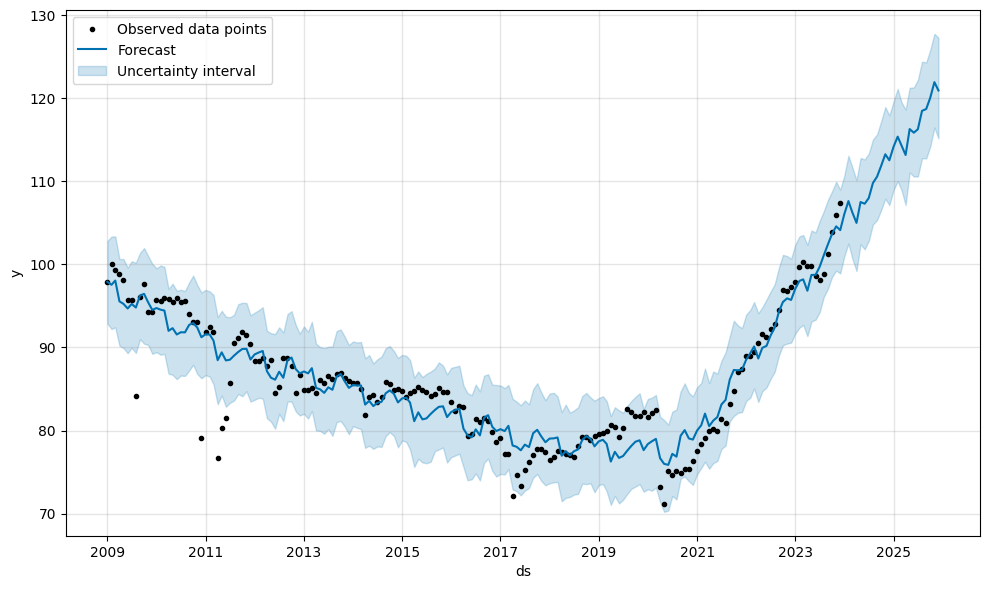

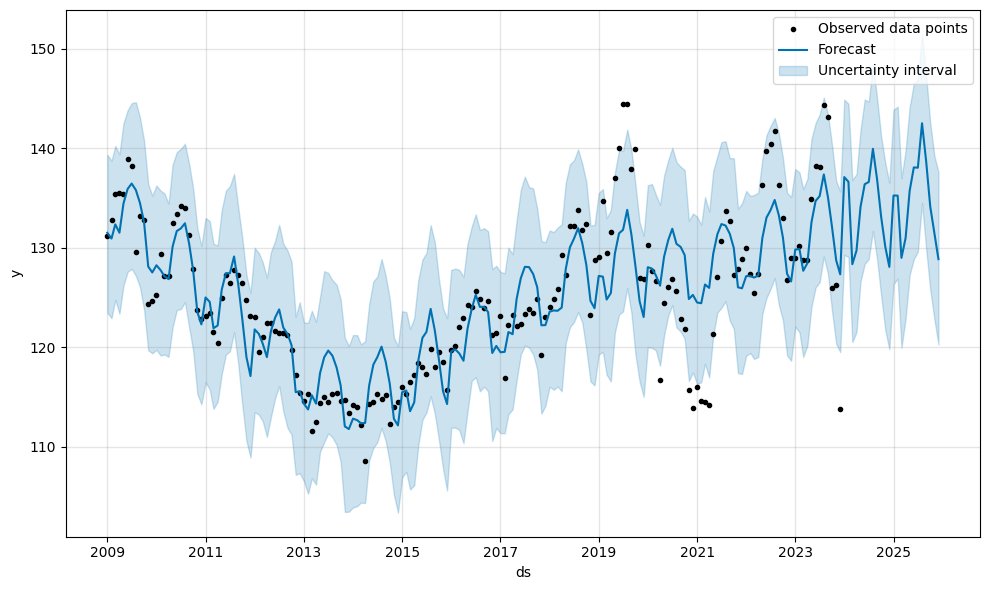

In [65]:
# Plot the forecast
fig=model_oil.plot(forecast_oil, include_legend=True)
fig=model_gas.plot(forecast_gas, include_legend=True)

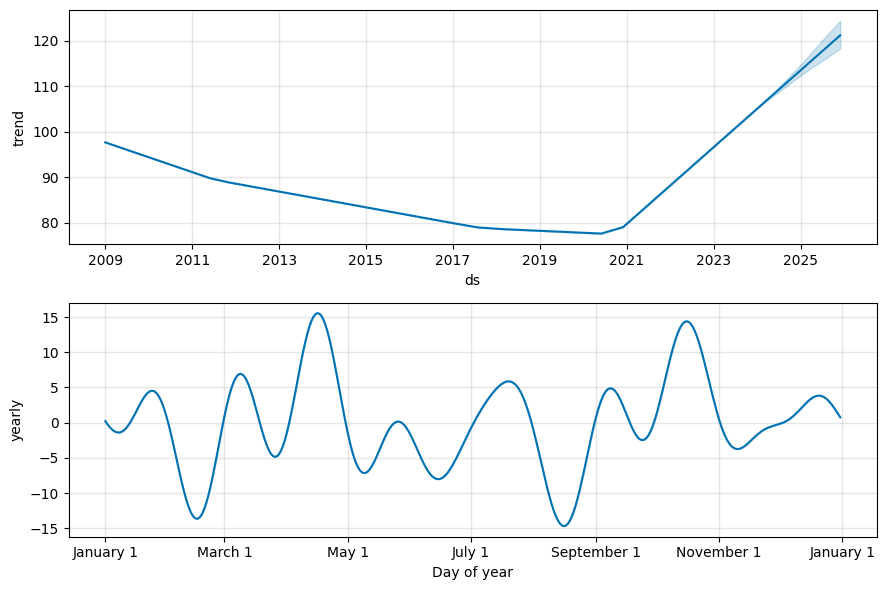

In [66]:
fig_components_oil = model_oil.plot_components(forecast_oil)

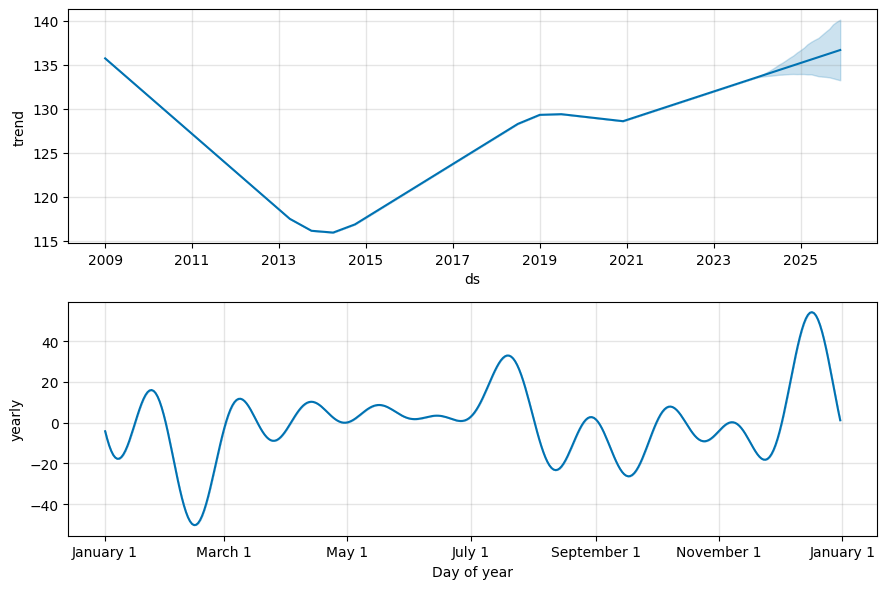

In [67]:
fig_components_gas = model_gas.plot_components(forecast_gas)

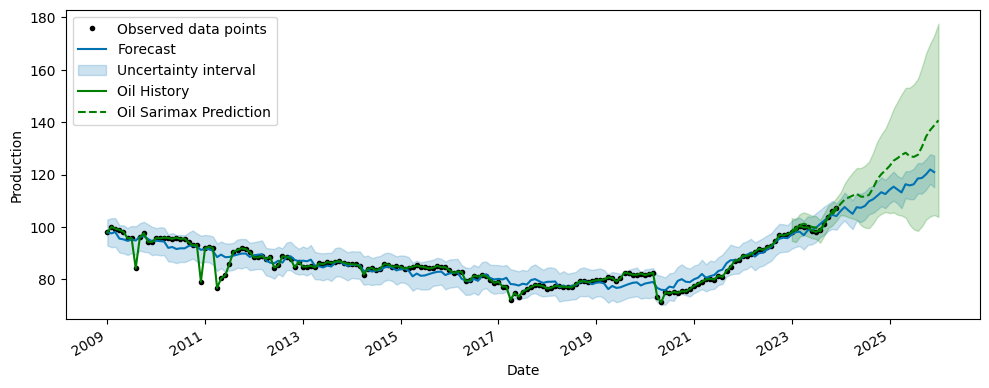

In [68]:
fig=model_oil.plot(forecast_oil, include_legend=True)
fig=df.loc['2009-01-01':,'produccion_petroleo_promedio_dia_km3'].plot(label = 'Oil History', 
                                           figsize =(10,4), color='green')
pred_oil.predicted_mean.plot(ax = fig, label = 'Oil Sarimax Prediction', color='green', linestyle='--')
fig.fill_between(pred_IC_oil.index, 
                 pred_IC_oil.iloc[:,0], pred_IC_oil.iloc[:,1], 
                 color='green', alpha=.2)

plt.ylabel('Production')
plt.legend()
plt.show()

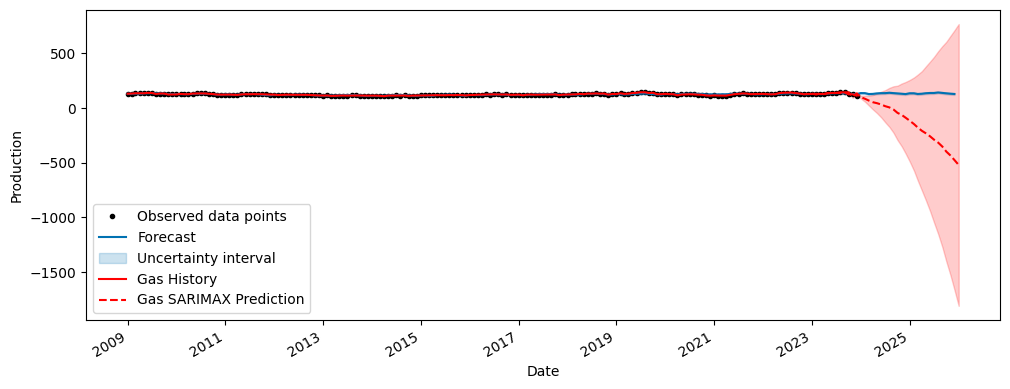

In [69]:
fig=model_gas.plot(forecast_gas, include_legend=True)
fig = df.loc['2009-01-01':,'produccion_gas_promedio_dia_Mm3'].plot(label = 'Gas History', 
                                           figsize =(10,4), color='red')
pred_gas.predicted_mean.plot(ax = fig, label = 'Gas SARIMAX Prediction', color='red', linestyle='--')
fig.fill_between(pred_IC_gas.index, 
                 pred_IC_gas.iloc[:,0], pred_IC_gas.iloc[:,1], 
                 color='red', alpha=.2)
plt.ylabel('Production')
plt.legend()
plt.show()


### Shocks o Punto de cambio

Si lo deseamos, podemos especificar manualmente las ubicaciones de posibles puntos de cambio con el argumento **changepoints**. 

Los puntos de cambio podrían limitarse por completo a un pequeño conjunto de fechas, como se hace aquí:

In [70]:
cp=['2011-11-01','2015-11-01','2019-11-01', '2020-03-01', '2023-11-01'] # COVID y Elecciones Presidenciales

In [71]:
model_oil_cp = Prophet(yearly_seasonality=True, interval_width=0.95, changepoints=cp)
model_gas_cp = Prophet(yearly_seasonality=True, interval_width=0.95, changepoints=cp)

In [72]:
model_oil_cp.fit(df_oil)
model_gas_cp.fit(df_gas)

10:16:09 - cmdstanpy - INFO - Chain [1] start processing
10:16:09 - cmdstanpy - INFO - Chain [1] done processing
10:16:09 - cmdstanpy - INFO - Chain [1] start processing
10:16:09 - cmdstanpy - INFO - Chain [1] done processing


In [73]:
future_oil_cp = model_oil_cp.make_future_dataframe(periods=24, freq='ME')
future_gas_cp= model_gas_cp.make_future_dataframe(periods=24, freq='ME')
forecast_oil_cp = model_oil_cp.predict(future_oil_cp)
forecast_gas_cp = model_gas_cp.predict(future_gas_cp)

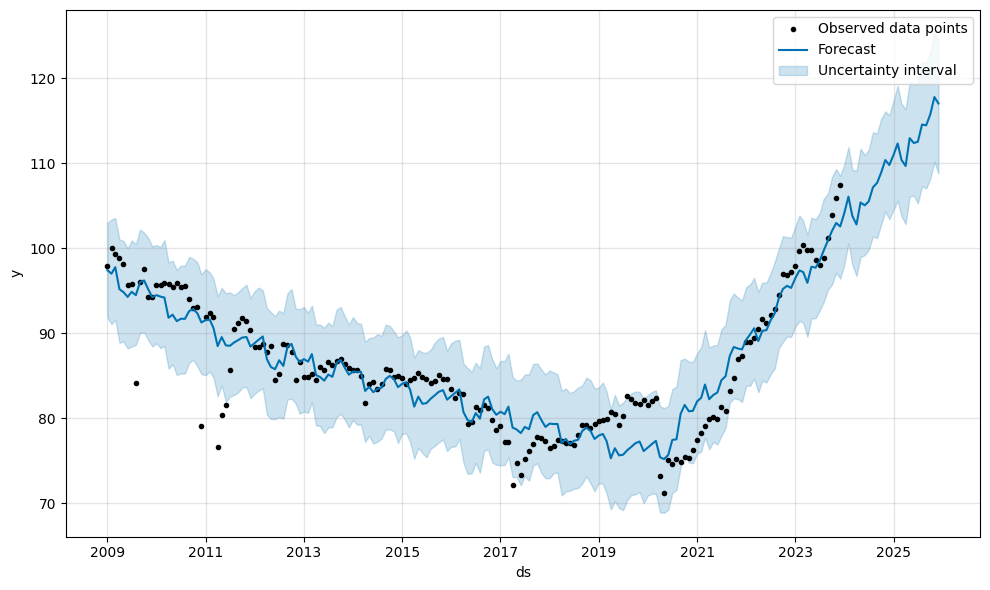

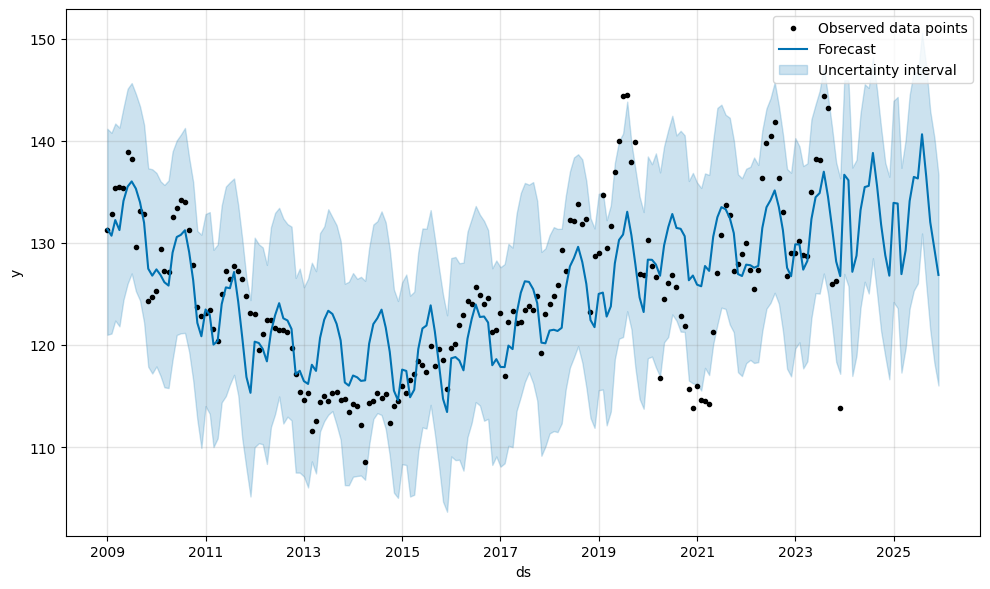

In [74]:
fig=model_oil_cp.plot(forecast_oil_cp, include_legend=True)
fig=model_gas_cp.plot(forecast_gas_cp, include_legend=True)

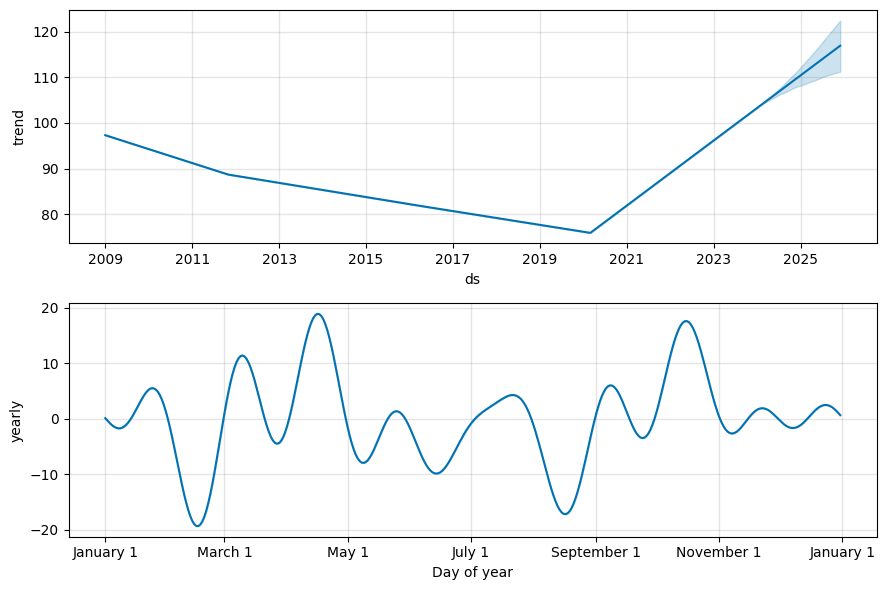

In [75]:
fig_components_oil_cp = model_oil_cp.plot_components(forecast_oil_cp)

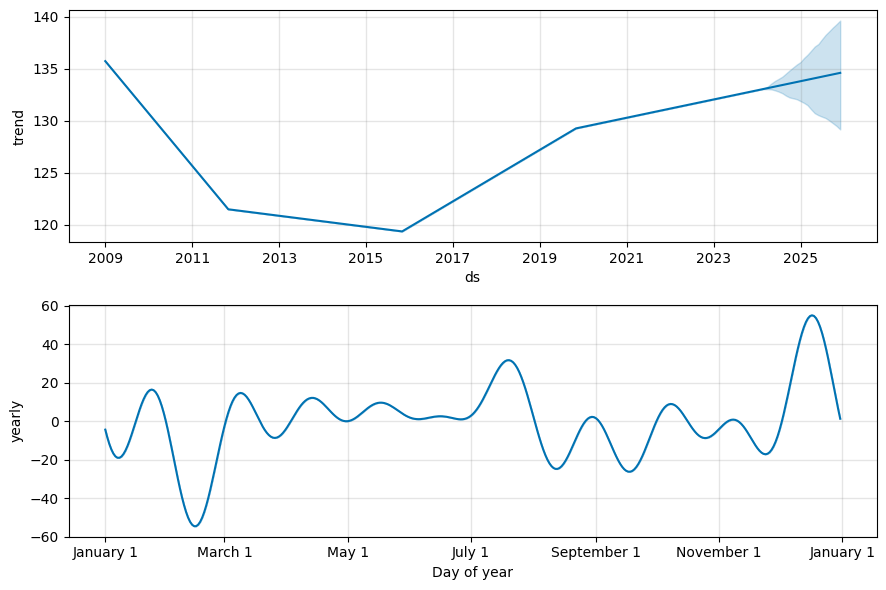

In [76]:
fig_components_gas_cp = model_gas_cp.plot_components(forecast_gas_cp)

Podemos detectarlos automaticamente sobre los modelos originales también:

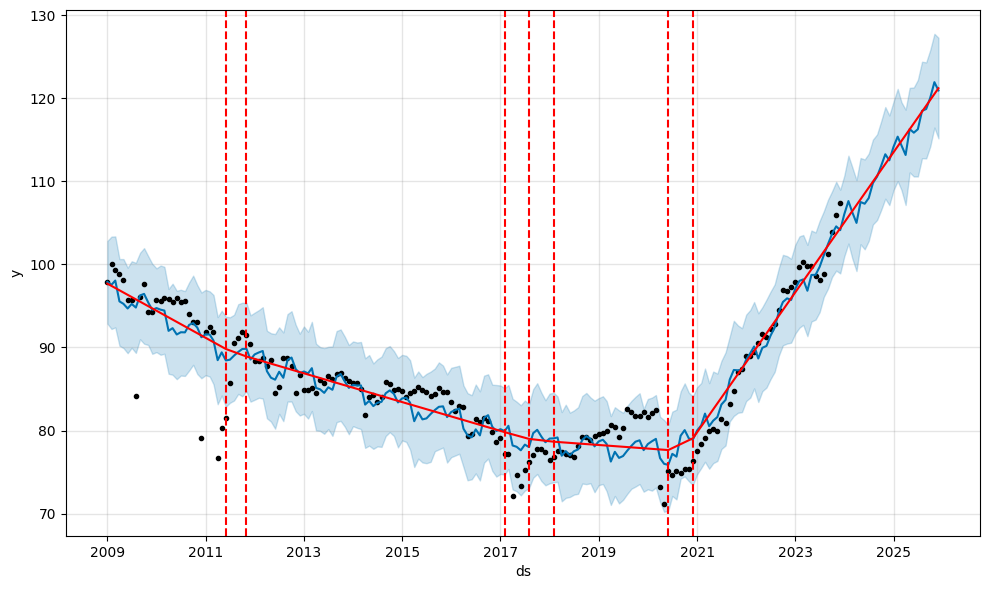

In [77]:
fig_aut = model_oil.plot(forecast_oil)
o_out = add_changepoints_to_plot(fig_aut.gca(), model_oil, forecast_oil)

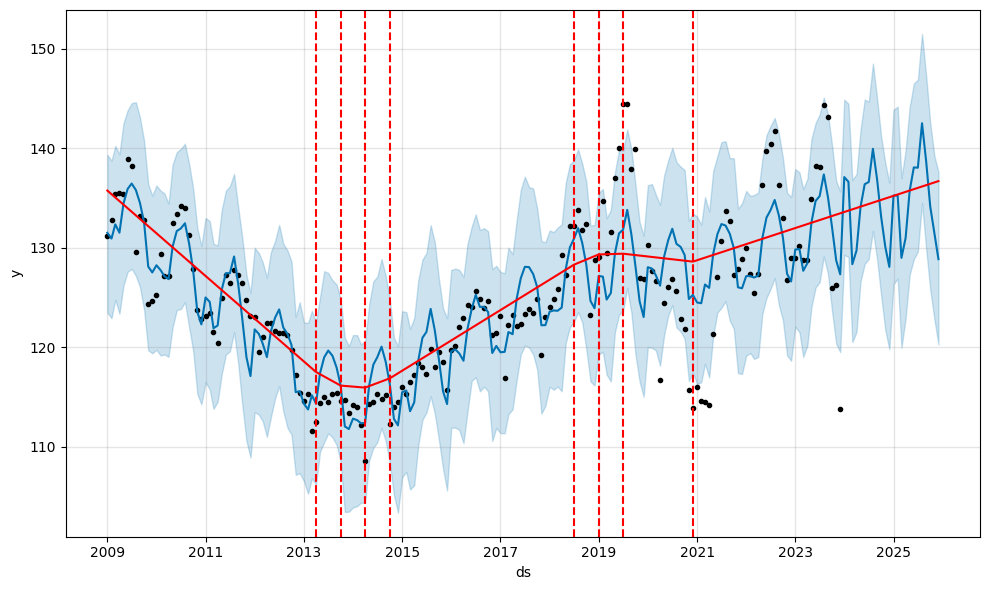

In [78]:
fig_aut = model_gas.plot(forecast_gas)
g_out = add_changepoints_to_plot(fig_aut.gca(), model_gas, forecast_gas)

**Entendiendo los Fundamentos**

¿Qué es SARIMAX y cómo extiende el modelo ARIMA?

¿Qué es Prophet y qué lo distingue de los modelos tradicionales de series de tiempo como SARIMAX?

**Componentes y Características del Modelo**

¿Cómo maneja SARIMAX la estacionalidad en los datos de series de tiempo?
        
¿Cómo maneja Prophet la estacionalidad y qué opciones proporciona para modelar diferentes estacionalidades?

¿Qué papel juegan las variables exógenas en SARIMAX y en qué se diferencian de los regresores en Prophet?

**Ajuste del Modelo y Predicción**

¿En qué se diferencian SARIMAX y Prophet en términos de ajuste del modelo y selección de parámetros?
       
Discuta la flexibilidad de SARIMAX y Prophet para manejar datos faltantes y valores atípicos.

**Consideraciones Prácticas**

¿Qué escenarios son más adecuados para SARIMAX versus Prophet, considerando factores como la estacionalidad de los datos, conocimiento del dominio y recursos computacionales?

¿Cómo se desempeñan SARIMAX y Prophet en términos de eficiencia computacional y escalabilidad con grandes conjuntos de datos?
       
¿Qué desafíos podrías enfrentar al implementar SARIMAX y Prophet para problemas de pronóstico en el mundo real?


![Lenguaje Matemático](./Images/Matematicas.png)

![Contacto](./Images/Contacto.png)